In [72]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
print("Shape of data:", df.shape)
print("\nInfo:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget value counts:")
print(df['Churn'].value_counts())


Shape of data: (7043, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperless

In [74]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

df.drop("customerID", axis=1, inplace=True)

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

df = pd.get_dummies(df, columns=[
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
], drop_first=True)



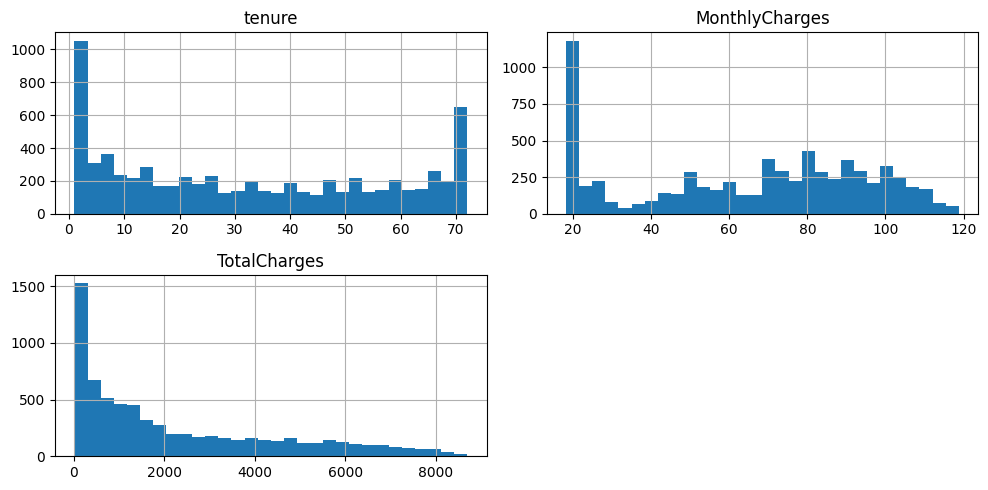

In [75]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df[num_features].hist(figsize=(10, 5), bins=30)
plt.tight_layout()
plt.show()


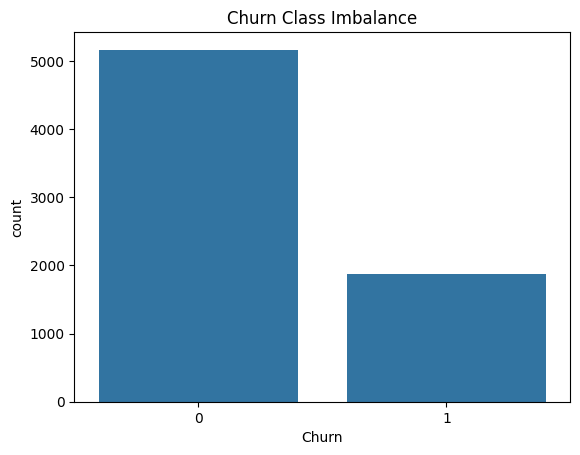

Top correlations with churn:
Churn                             1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
PaperlessBilling                  0.191454
SeniorCitizen                     0.150541
StreamingTV_Yes                   0.063254
StreamingMovies_Yes               0.060860
MultipleLines_Yes                 0.040033
PhoneService                      0.011691
Name: Churn, dtype: float64


In [76]:
# Class balance
sns.countplot(x='Churn', data=df)
plt.title('Churn Class Imbalance')
plt.show()

# Correlation with target
correlation = df.corr()['Churn'].sort_values(ascending=False)
print("Top correlations with churn:")
print(correlation.head(10))


In [91]:
# Tenure buckets (e.g., <12 months = new, 12–24 = medium, >24 = loyal)
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, np.inf],
                            labels=['0–12m', '12–24m', '24–48m', '48–60m', '60m+'])

# Binary feature: new_customer
df['is_new_customer'] = (df['tenure'] <= 6).astype(int)

# Average monthly payment over tenure
df['avg_monthly_spend'] = df['TotalCharges'] / (df['tenure'] + 1)

# Flag: customer paying high but not on long-term contract
df['high_spend_no_contract'] = ((df['MonthlyCharges'] > 80) &
                                (df['Contract_One year'] == 0) &
                                (df['Contract_Two year'] == 0)).astype(int)

# Bill shock: steep monthly bills for new users
df['bill_shock'] = ((df['MonthlyCharges'] > 85) & (df['tenure'] < 3)).astype(int)

# Average monthly payment over tenure
df['avg_monthly_spend'] = df['TotalCharges'] / (df['tenure'] + 1)

# Flag: customer paying high but not on long-term contract
df['high_spend_no_contract'] = ((df['MonthlyCharges'] > 80) &
                                (df['Contract_One year'] == 0) &
                                (df['Contract_Two year'] == 0)).astype(int)

# Bill shock: steep monthly bills for new users
df['bill_shock'] = ((df['MonthlyCharges'] > 85) & (df['tenure'] < 3)).astype(int)

# Count how many services the customer has
service_cols = [
    'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
    'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes'
]
df['num_services'] = df[service_cols].sum(axis=1)

# Is customer using no services at all
df['no_services'] = df['num_services'] == 0

# Has both streaming services
df['has_full_streaming'] = ((df['StreamingTV_Yes'] == 1) &
                            (df['StreamingMovies_Yes'] == 1)).astype(int)

# Is electronic check (most risky group)
df['is_electronic_check'] = df['PaymentMethod_Electronic check']

# Digital friendly user
df['is_digital_friendly'] = ((df['PaperlessBilling'] == 1) &
                             (df['PaymentMethod_Credit card (automatic)'] == 1)).astype(int)

df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)


In [92]:
corr = df.corr()['Churn'].sort_values(ascending=False)
print("Top positively correlated with churn:\n", corr.head(10))
print("\nTop negatively correlated with churn:\n", corr.tail(10))


Top positively correlated with churn:
 Churn                             1.000000
is_new_customer                   0.311364
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
is_electronic_check               0.301455
high_spend_no_contract            0.296955
MonthlyCharges                    0.192858
PaperlessBilling                  0.191454
SeniorCitizen                     0.150541
bill_shock                        0.143565
Name: Churn, dtype: float64

Top negatively correlated with churn:
 tenure_group_60m+                      -0.226078
OnlineSecurity_No internet service     -0.227578
OnlineBackup_No internet service       -0.227578
StreamingMovies_No internet service    -0.227578
TechSupport_No internet service        -0.227578
StreamingTV_No internet service        -0.227578
DeviceProtection_No internet service   -0.227578
InternetService_No                     -0.227578
Contract_Two year                      -0.301552
tenure                

In [97]:
df.shape

(7032, 44)

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier



X_lr_svm = df.drop('Churn', axis=1)
y = df['Churn']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_lrsvm, X_test_lrsvm, y_train_lrsvm, y_test_lrsvm = train_test_split(
    X_lr_svm, y, test_size=0.2, random_state=42, stratify=y
)

scaler_lrsvm = StandardScaler()
X_train_lrsvm_scaled = scaler_lrsvm.fit_transform(X_train_lrsvm)
X_test_lrsvm_scaled = scaler_lrsvm.transform(X_test_lrsvm)

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_lrsvm_scaled, y_train_lrsvm)
lr_pred = lr.predict(X_test_lrsvm_scaled)
lr_proba = lr.predict_proba(X_test_lrsvm_scaled)[:, 1]

# SVM
svm = SVC(kernel='linear', class_weight='balanced', probability=True)
svm.fit(X_train_lrsvm_scaled, y_train_lrsvm)
svm_pred = svm.predict(X_test_lrsvm_scaled)
svm_proba = svm.predict_proba(X_test_lrsvm_scaled)[:, 1]


In [94]:
from imblearn.over_sampling import SMOTE

X_knn_nb = df.drop('Churn', axis=1)  # full feature set
y = df['Churn']

X_train_knnnb, X_test_knnnb, y_train_knnnb, y_test_knnnb = train_test_split(
    X_knn_nb, y, test_size=0.2, random_state=42, stratify=y
)

# Scale before SMOTE (important)
scaler_knnnb = StandardScaler()
X_train_knnnb_scaled = scaler_knnnb.fit_transform(X_train_knnnb)
X_test_knnnb_scaled = scaler_knnnb.transform(X_test_knnnb)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_knnnb_resampled, y_train_knnnb_resampled = smote.fit_resample(X_train_knnnb_scaled, y_train_knnnb)

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knnnb_resampled, y_train_knnnb_resampled)
knn_pred = knn.predict(X_test_knnnb_scaled)
knn_proba = knn.predict_proba(X_test_knnnb_scaled)[:, 1]

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_knnnb_resampled, y_train_knnnb_resampled)
nb_pred = nb.predict(X_test_knnnb_scaled)
nb_proba = nb.predict_proba(X_test_knnnb_scaled)[:, 1]




In [95]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n📊 {name} Evaluation Metrics:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_true, y_proba))



In [96]:
evaluate_model("Logistic Regression (Top Features)", y_test_lrsvm, lr_pred, lr_proba)
evaluate_model("SVM (Top Features)", y_test_lrsvm, svm_pred, svm_proba)
evaluate_model("KNN (SMOTE)", y_test_knnnb, knn_pred, knn_proba)
evaluate_model("Naive Bayes (SMOTE)", y_test_knnnb, nb_pred, nb_proba)



📊 Logistic Regression (Top Features) Evaluation Metrics:
[[732 301]
 [ 78 296]]
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407

ROC-AUC Score: 0.8376529085628796

📊 SVM (Top Features) Evaluation Metrics:
[[661 372]
 [ 69 305]]
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1033
           1       0.45      0.82      0.58       374

    accuracy                           0.69      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.78      0.69      0.70      1407

ROC-AUC Score: 0.8229793809629811

📊 KNN (SMOTE) Evaluation Metrics:
[[701 332]
 [ 98 276]]
              precision    recall  f1-score   support

           0       

In [99]:
# Get feature names and coefficients
feature_names = X_train_lrsvm.columns
coefficients = lr.coef_[0]

# Create DataFrame for importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute value of coefficients
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)
importance_df.head(20)

,Feature,Coefficient,Abs_Coefficient
11,InternetService_Fiber optic,0.919443,0.919443
31,avg_monthly_spend,-0.827436,0.827436
26,Contract_Two year,-0.756345,0.756345
4,tenure,-0.601463,0.601463
7,MonthlyCharges,-0.465741,0.465741
25,Contract_One year,-0.358795,0.358795
8,TotalCharges,0.283081,0.283081
10,MultipleLines_Yes,0.277902,0.277902
22,StreamingTV_Yes,0.258205,0.258205
24,StreamingMovies_Yes,0.245115,0.245115


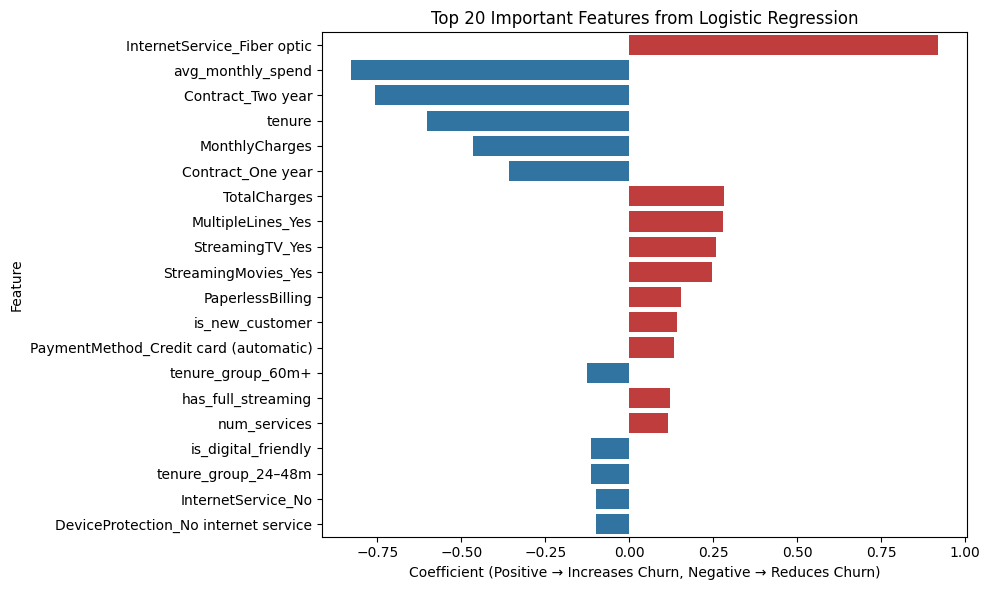

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = importance_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(y='Feature', x='Coefficient', data=top_features,
            palette=['#d62728' if c > 0 else '#1f77b4' for c in top_features['Coefficient']])
plt.title("Top 20 Important Features from Logistic Regression")
plt.xlabel("Coefficient (Positive → Increases Churn, Negative → Reduces Churn)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
